In [1]:
import json
import numpy as np
import pandas as pd
import plotly.express as px

In [2]:
with open("source_space_results.json") as in_file:
    data = json.loads(in_file.read())

In [3]:
records = []
for subject, subject_data in data.items():
    for lobe, lobe_data in subject_data.items():
        for i, (tau, p) in enumerate(zip(lobe_data["tau"], lobe_data["p"])):
            records.append(dict(subject=subject, timestamp=(i-200)/1000, lobe=lobe, tau=tau, p=p[-1], model="lr"))

In [4]:
df = pd.DataFrame.from_records(records)

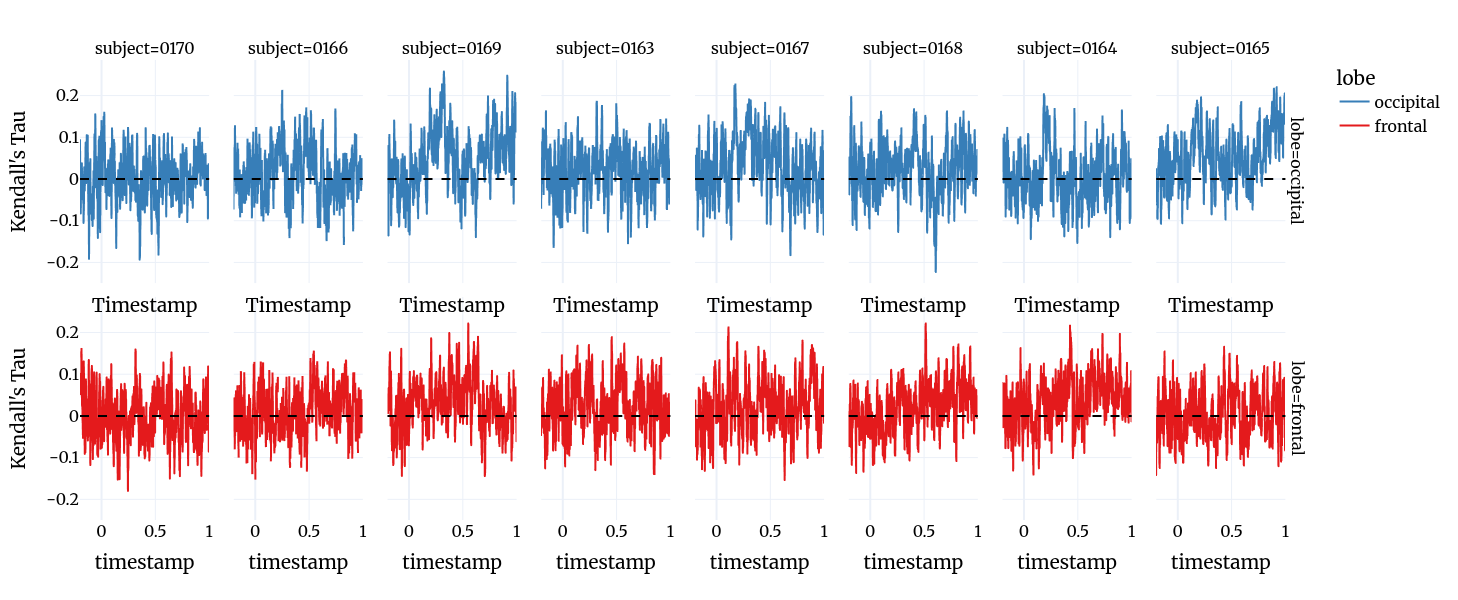

In [5]:
color_map = dict(zip(["frontal", "occipital"], px.colors.qualitative.Set1))
fig = px.line(df, x="timestamp", y="tau", color="lobe", facet_col="subject", facet_row="lobe", color_discrete_map=color_map)
#fig = fig.update_traces(showlegend=False)
fig = fig.update_layout(
    template="plotly_white",
    width=1400,
    height=600,
    font=dict(family="Merriweather", size=16, color="black"),
)
fig = fig.update_yaxes(title="Kendall's Tau", col=1)
fig = fig.update_xaxes(title="Timestamp", row=2)
fig = fig.add_hline(y=0, line=dict(color="black", dash="dash"))
fig.show()

In [228]:
from scipy.stats import combine_pvalues, false_discovery_control
from functools import partial

combined_p = df.groupby(["lobe", "timestamp"])["p"].agg(lambda p: combine_pvalues(p, nan_policy="omit").pvalue)
combined_p = combined_p.reset_index()
combined_p["p"] = false_discovery_control(combined_p["p"], method="bh")
combined_p = combined_p.sort_values(["lobe","timestamp"])

In [229]:
alpha_level = 0.05
significant_regions = dict()
for lobe, ps in combined_p.groupby("lobe"):
    p = ps["p"]
    significant_periods = np.where(np.diff(p < alpha_level))[0]
    if len(significant_periods) % 2:
        significant_periods = np.append(significant_periods, 1201)
    significant_periods = significant_periods.reshape(-1, 2)
    significant_periods = (significant_periods - 200)/1000
    significant_regions[lobe] = significant_periods

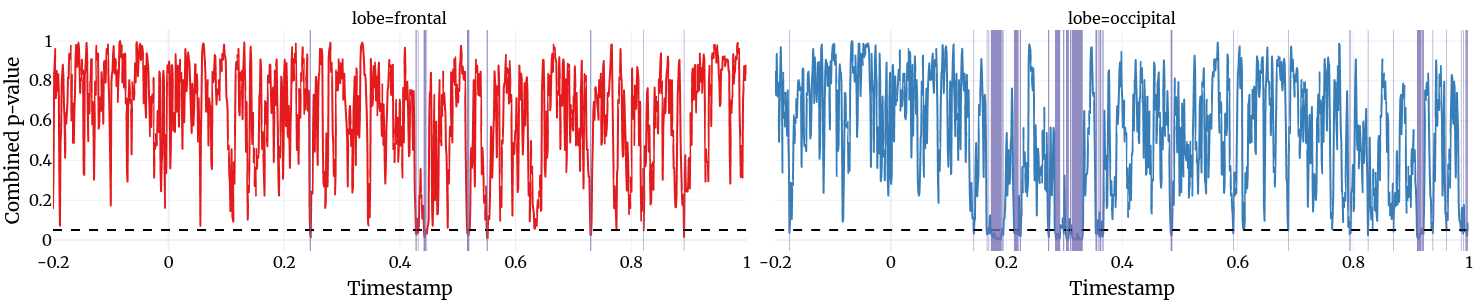

In [230]:

fig = px.line(combined_p, x="timestamp", y="p", facet_col="lobe", color="lobe", color_discrete_map=color_map)
fig = fig.add_hline(y=0.05, line=dict(color="black", dash="dash"))
fig = fig.update_traces(showlegend=False)
fig = fig.update_layout(
    template="plotly_white",
    yaxis_title="Combined p-value", 
    width=1200,
    height=300,
    font=dict(family="Merriweather", size=16, color="black"),
    margin=dict(l=0, r=0, t=30, b=0),
)
fig = fig.update_xaxes(title="Timestamp")
for col, lobe in enumerate(["frontal", "occipital"]):
    regions = significant_regions[lobe]
    for x0, x1 in regions:
        fig.add_vrect(
            x0=x0, x1=x1,
            fillcolor="#7570B3", opacity=0.8,
            layer="above", line_width=0, col=col+1
        )
fig.show()

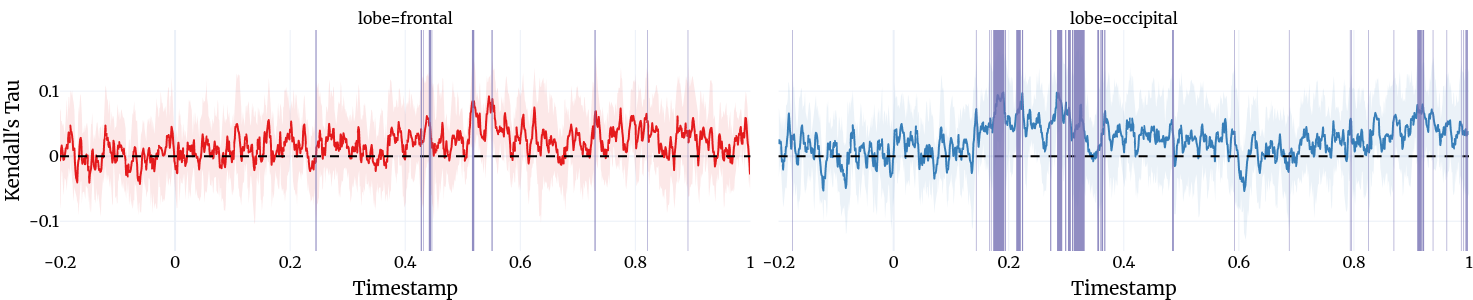

In [231]:
taus = df.groupby(["lobe", "timestamp"])["tau"].mean().reset_index()
fig = px.line(taus, x="timestamp", y="tau", color="lobe", facet_col="lobe", color_discrete_map=color_map)
fig = fig.add_hline(y=0, line=dict(color="black", dash="dash"))
fig = fig.update_traces(showlegend=False)
for lobe, lobe_df in df.groupby("lobe"):
    m_tau = lobe_df.groupby("timestamp")["tau"].mean().sort_index()
    std_tau = lobe_df.groupby("timestamp")["tau"].std().sort_index()
    fig = fig.add_scatter(
        name='Upper Bound',
        x=timestamps,
        y=m_tau+std_tau,
        mode='lines',
        line=dict(width=0),
        showlegend=False,
        col=1 if lobe=="frontal" else 2,
        row=1,
    )
    fig = fig.add_scatter(
        name='Lower Bound',
        x=timestamps,
        y=m_tau-std_tau,
        line=dict(width=0),
        mode='lines',
        fillcolor="rgba(228,26,28,0.1)" if lobe=="frontal" else "rgba(55,126,184, 0.1)",
        fill='tonexty',
        showlegend=False,
        col=1 if lobe=="frontal" else 2,
        row=1
    )
fig = fig.update_layout(
    template="plotly_white",
    yaxis_title="Kendall's Tau", 
    width=1200,
    height=300,
    font=dict(family="Merriweather", size=16, color="black"),
    margin=dict(l=0, r=0, t=30, b=0),
)
fig = fig.update_xaxes(title="Timestamp")
for col, lobe in enumerate(["frontal", "occipital"]):
    regions = significant_regions[lobe]
    for x0, x1 in regions:
        fig.add_vrect(
            x0=x0, x1=x1,
            fillcolor="#7570B3", opacity=0.8,
            layer="above", line_width=0, col=col+1
        )
fig.show()